In [1]:
import pandas as pd
import dask.dataframe as dd
import os
import networkx as nx
import numpy as np

LINKS_FOLDER = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\LINKS\clean_release_links"
RELEASES_PATH = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\releases_v2.csv"
MAIN_TABLE_PATH = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\full_table.csv"
STATS_BATCHES_PATH = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\city_graph_stats_batches"
OUTPATH = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\city_graph_stats.csv"

releases = dd.read_csv(RELEASES_PATH)
releases_head = releases.head(1000)
releases_head.columns

main_table = dd.read_csv(MAIN_TABLE_PATH, dtype={'artist_id': 'object'})

In [2]:
#fetch relevant artists (original function - now mainly for reference)
def filter_batch(iteration, filtered_base_frame):
    # Load links for this iteration
    links_path = os.path.join(LINKS_FOLDER, f"clean_links_{iteration}.csv")
    links = dd.read_csv(links_path, dtype={'artist_id': 'object'})
    
    result = links.merge(filtered_base_frame, on='release_id', how='inner')
    result = result.rename(columns={'artist_id_x': 'colab_artist_id', 'artist_id_y': 'main_artist_id'})
    result = result[['colab_artist_id', 'master_id']].drop_duplicates() #DOES NOT INCLUDE ROLE
    
    return result  # Return dask frame

def filter_links(city=None, genre=None, style=None, start_year=None, end_year=None):
    # Filter main_table first
    filtered_main = main_table
    if city is not None:
        filtered_main = filtered_main.query(f'city=="{city}"')
    if genre is not None:
        filtered_main = filtered_main.query(f'genre=="{genre}"')
    if style is not None:
        filtered_main = filtered_main.query(f'style=="{style}"')
    if start_year is not None:
        filtered_main = filtered_main.query(f'year>={start_year}')
    if end_year is not None:
        filtered_main = filtered_main.query(f'year>={end_year}')
    
    # Then merge with releases
    df = releases.merge(filtered_main, on='master_id', how='inner')
    df = df[['release_id', 'master_id', 'artist_id']]
    #at this point our dataframe identifies the releases necessary
    #we now pull those releases from our master_artist_links files using the above function
    outframe = None
    for x in range(0,17):
        if outframe is None:
            outframe = filter_batch(x, df)
        else:
            outframe = dd.concat([outframe, filter_batch(x, df)])
    return outframe

def generate_links(input_table):
    """
        links generation taking the filtered table as input rather than 
    """
    # Then merge with releases
    df = releases.merge(input_table, on='master_id', how='inner')
    df = df[['release_id', 'master_id', 'artist_id']]
    #at this point our dataframe identifies the releases necessary
    #we now pull those releases from our master_artist_links files using the above function
    outframe = None
    for x in range(0,17):
        if outframe is None:
            outframe = filter_batch(x, df)
        else:
            outframe = dd.concat([outframe, filter_batch(x, df)])
    return outframe

In [3]:
# Old function - keeping for reference
def build_unweighted_graph(df):
    # Extract unique artist-master pairs
    df = df[['colab_artist_id', 'master_id']].drop_duplicates()
    
    # Self-join on master_id to find artist collaborations
    outframe = df.merge(df, on='master_id', how='inner')
    
    # Filter to avoid duplicate pairs and self-pairs
    outframe = outframe.query('colab_artist_id_x > colab_artist_id_y')
    
    # Group by artist pairs and count collaborations (translating SQL GROUP BY)
    outframe = outframe.groupby(['colab_artist_id_x', 'colab_artist_id_y'])['master_id'].count().reset_index()
    outframe = outframe.rename(columns={'master_id': 'weight', 'colab_artist_id_x': 'artist_id_x', 'colab_artist_id_y': 'artist_id_y'})
    
    return outframe

In [4]:
def build_graph_stats(graph):
    G = nx.Graph()

    # Add weighted edges from artist_links
    for _, row in graph.iterrows():
        G.add_edge(row['artist_id_x'], row['artist_id_y'], weight=row['weight'])

    # Number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    if num_nodes == 0:
        return pd.Series({
            'num_nodes': 0, 'num_edges': 0, 'density': 0, 'components': 0,
            'largest_cc_size': 0, 'avg_degree': 0, 'max_degree': 0, 'min_degree': 0, 'entropy': 0
        })


    # Basic diagnostics
    density = nx.density(G)
    components = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    largest_cc_size = len(largest_cc)
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    degrees = [d for n, d in G.degree()]
    max_degree = max(degrees)
    min_degree = min(degrees)
    # Calculate the degree distribution
    degree_counts = np.array(list(dict(G.degree()).values()))
    degree_prob = degree_counts / degree_counts.sum()

    # Calculate entropy
    entropy = -np.sum(degree_prob * np.log2(degree_prob + 1e-12))
    stats = {
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'density': density,
        'components': components,
        'largest_cc_size': largest_cc_size,
        'avg_degree': avg_degree,
        'max_degree': max_degree,
        'min_degree': min_degree,
        'entropy': entropy
    }
    return pd.Series(stats)

In [5]:
def build_summary_stats(df):
    # df is a computed pandas DataFrame
    if df.empty:
        return pd.Series({
            'num_releases': 0,
            'num_master_ids': 0,
            'releases_per_master_mean': 0,
            'releases_per_master_median': 0,
            'releases_per_master_10th': 0,
            'releases_per_master_25th': 0,
            'releases_per_master_75th': 0,
            'releases_per_master_90th': 0
        })

    releases_per_master = df.groupby('master_id').size()
    
    stats = {
        'num_releases': len(df),
        'num_master_ids': df['master_id'].nunique(),
        'releases_per_master_mean': releases_per_master.mean(),
        'releases_per_master_median': releases_per_master.median(),
        'releases_per_master_10th': releases_per_master.quantile(0.1),
        'releases_per_master_25th': releases_per_master.quantile(0.25),
        'releases_per_master_75th': releases_per_master.quantile(0.75),
        'releases_per_master_90th': releases_per_master.quantile(0.9)
    }
    return pd.Series(stats)


In [6]:
def process_city(city=None, genre=None, style=None, start_year=None, end_year=None):
    filtered_main = main_table
    if city is not None:
        filtered_main = filtered_main.query(f'city=="{city}"')
    if genre is not None:
        filtered_main = filtered_main.query(f'genre=="{genre}"')
    if style is not None:
        filtered_main = filtered_main.query(f'style=="{style}"')
    if start_year is not None:
        filtered_main = filtered_main.query(f'year>={start_year}')
    if end_year is not None:
        filtered_main = filtered_main.query(f'year<{end_year}')
    
    print(f"Computing for city={city}, genre={genre}, style={style}, start_year={start_year}, end_year={end_year}")

    computed_filtered_main = filtered_main.compute()
    summary_stats = build_summary_stats(computed_filtered_main)
    
    links = generate_links(filtered_main)
    computed_links = links.compute()
    
    if computed_links.empty:
        graph_stats = pd.Series({
            'num_nodes': 0, 'num_edges': 0, 'density': 0, 'components': 0,
            'largest_cc_size': 0, 'avg_degree': 0, 'max_degree': 0, 'min_degree': 0, 'entropy': 0
        })
    else:
        graph = build_unweighted_graph(computed_links)
        graph_stats = build_graph_stats(graph)

    params = pd.Series({
        'city': city, 'genre': genre, 'style': style, 
        'start_year': start_year, 'end_year': end_year
    })
    
    return pd.concat([params, summary_stats, graph_stats])
    
    

In [ ]:
import time
import concurrent.futures
from threading import Lock

# Filter cities to those with more than 200 masters and order by size
print("Filtering cities with more than 200 masters...")
city_master_counts = main_table.groupby('city')['master_id'].nunique().compute()
filtered_cities = city_master_counts[city_master_counts > 200].sort_values(ascending=False)

print(f"Found {len(filtered_cities)} cities with more than 200 masters:")
for city, count in filtered_cities.head(10).items():
    print(f"  {city}: {count} masters")
print("...")

# Thread-safe printing
print_lock = Lock()

def process_single_city(city):
    """Process a single city and save results"""
    city_results = []
    batch_path = os.path.join(STATS_BATCHES_PATH, f"{city}.csv")
    
    # Check if batch already exists
    if os.path.exists(batch_path):
        with print_lock:
            print(f"Batch file for {city} already exists, skipping...")
        return None
    
    with print_lock:
        print(f"\nProcessing {city} ({filtered_cities[city]} masters)...")
    
    x = 1950
    city_start_time = time.time()
    
    while True:
        if x > 2015: #cutoff after 20155
            break
        eyear = x + 10
        
        iter_start_time = time.time()
        
        result_series = process_city(city=city, start_year=x, end_year=eyear)
        city_results.append(result_series)
        
        iter_end_time = time.time()
        with print_lock:
            print(f"  {city} {x}-{eyear} took {iter_end_time - iter_start_time:.2f} seconds.")
        
        x = x + 5
        
    if city_results:
        city_df = pd.DataFrame(city_results)
        # Save to the batch path
        city_df.to_csv(batch_path, index=False)
        city_end_time = time.time()
        with print_lock:
            print(f"  Saved batch for {city} to {batch_path} (city took {city_end_time - city_start_time:.2f} seconds)")
        return city_df
    
    return None

# Process all filtered cities using multithreading
outframe = pd.DataFrame()
total_start_time = time.time()



Filtering cities with more than 200 masters...
Found 85 cities with more than 200 masters:
  London2: 14972 masters
  New York: 14027 masters
  Los Angeles1: 11061 masters
  Paris: 5817 masters
  Pasadena2: 4410 masters
  Nashville: 3516 masters
  San Francisco1: 3106 masters
  Chicago: 2958 masters
  Philadelphia: 2199 masters
  Detroit: 2187 masters
...


In [ ]:
# Sequential process cities
all_results = []
for city in filtered_cities.index:
    batch_path = os.path.join(STATS_BATCHES_PATH, f"{city}.csv")
    
    if os.path.exists(batch_path): #check for existing batch file - used during long run sequences
        print(f"Batch file for {city} already exists, loading from file...")
        try:
            city_df = pd.read_csv(batch_path)
            all_results.append(city_df)
        except pd.errors.EmptyDataError:
            print(f"Warning: Batch file for {city} is empty. Skipping.")
        continue

    print(f"BEGINNING PROCESSING FOR {city}")
    city_df = process_single_city(city)
    if city_df is not None and not city_df.empty:
        all_results.append(city_df)

# Concatenate all results into the final outframe
if all_results:
    outframe = pd.concat(all_results, ignore_index=True)
else:
    outframe = pd.DataFrame()

total_end_time = time.time()
print(f"\nTotal processing time: {total_end_time - total_start_time:.2f} seconds.")

Batch file for London2 already exists, loading from file...
Batch file for New York already exists, loading from file...
Batch file for Los Angeles1 already exists, loading from file...
Batch file for Paris already exists, loading from file...
Batch file for Pasadena2 already exists, loading from file...
Batch file for Nashville already exists, loading from file...
Batch file for San Francisco1 already exists, loading from file...
Batch file for Chicago already exists, loading from file...
Batch file for Philadelphia already exists, loading from file...
Batch file for Detroit already exists, loading from file...
Batch file for Sydney1 already exists, loading from file...
Batch file for Melbourne2 already exists, loading from file...
Batch file for Toronto already exists, loading from file...
Batch file for Milan already exists, loading from file...
Batch file for Berlin already exists, loading from file...
Batch file for Kingston1 already exists, loading from file...
Batch file for Sto

In [25]:
outframe.to_csv(r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\city_stats.csv", index=False)

In [26]:
#dummy cell

In [16]:
GENRE = "Jazz"
CITY = "New York"
STYLE = "Hard bop"

# Get filtered releases
filtered_df = filter_links(CITY, GENRE, None, 1955, 1965)

In [ ]:
test_frame = build_unweighted_graph(filtered_df)

#test_frame.head()

# Compute the Dask DataFrame to get a pandas DataFrame
artist_links = test_frame.compute()



In [ ]:
import networkx as nx
# Instantiate a weighted undirected graph
G = nx.Graph()

# Add weighted edges from artist_links
for _, row in artist_links.iterrows():
    G.add_edge(row['artist_id_x'], row['artist_id_y'], weight=row['weight'])

# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Basic diagnostics
density = nx.density(G)
components = nx.number_connected_components(G)
largest_cc = max(nx.connected_components(G), key=len)
largest_cc_size = len(largest_cc)
avg_degree = sum(dict(G.degree()).values()) / num_nodes
degrees = [d for n, d in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Graph density: {density:.4f}")
print(f"Number of connected components: {components}")
print(f"Largest connected component size: {largest_cc_size}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Max degree: {max_degree}")
print(f"Min degree: {min_degree}")



ValueError: max() iterable argument is empty

In [ ]:
# Calculate degree centrality for each artist node
centrality = nx.degree_centrality(G)

# Convert to DataFrame for display
centrality_df = pd.DataFrame(list(centrality.items()), columns=['artist_id', 'degree_centrality'])

# Show the table
centrality_df.sort_values('degree_centrality', ascending=False).head(20)

,artist_id,degree_centrality
510,275139,0.063707
64,293996,0.038686
257,2318544,0.033524
417,740272,0.031337
66,264498,0.030366
294,259758,0.028179
509,2175437,0.027572
3181,254262,0.026661
1224,260215,0.026297
407,297469,0.023746


In [ ]:
# Merge centrality_df with artists table to get artist_name for each artist_id

artists = dd.read_csv(r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\artists_v1.csv")

artists = artists[['artist_id', 'name']].compute()
artists['artist_id'] = artists['artist_id'].astype('str')  # Convert to string to match centrality_df
artists = artists.drop_duplicates()

centrality_named = centrality_df.merge(artists, 
                                       left_on='artist_id', right_on='artist_id', how='left')

# Show the top artists by degree centrality with their names
centrality_named.sort_values('degree_centrality', ascending=False).head(10)

,artist_id,degree_centrality,name
510,275139,0.063707,Alan Douches
64,293996,0.038686,Paul Miner
257,2318544,0.033524,The Agency Group
417,740272,0.031337,Brad Boatright
66,264498,0.030366,Roger Miret
294,259758,0.028179,Ted Jensen
509,2175437,0.027572,Tim Borror
3181,254262,0.026661,Howie Weinberg
1224,260215,0.026297,Jason Livermore
407,297469,0.023746,Mike Fasano


In [ ]:
# Save test_frame to CSV in the specified folder
output_path = r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\data\explorations\jazz_all_ugraph.csv"
#artist_links.to_csv(output_path, index=False)

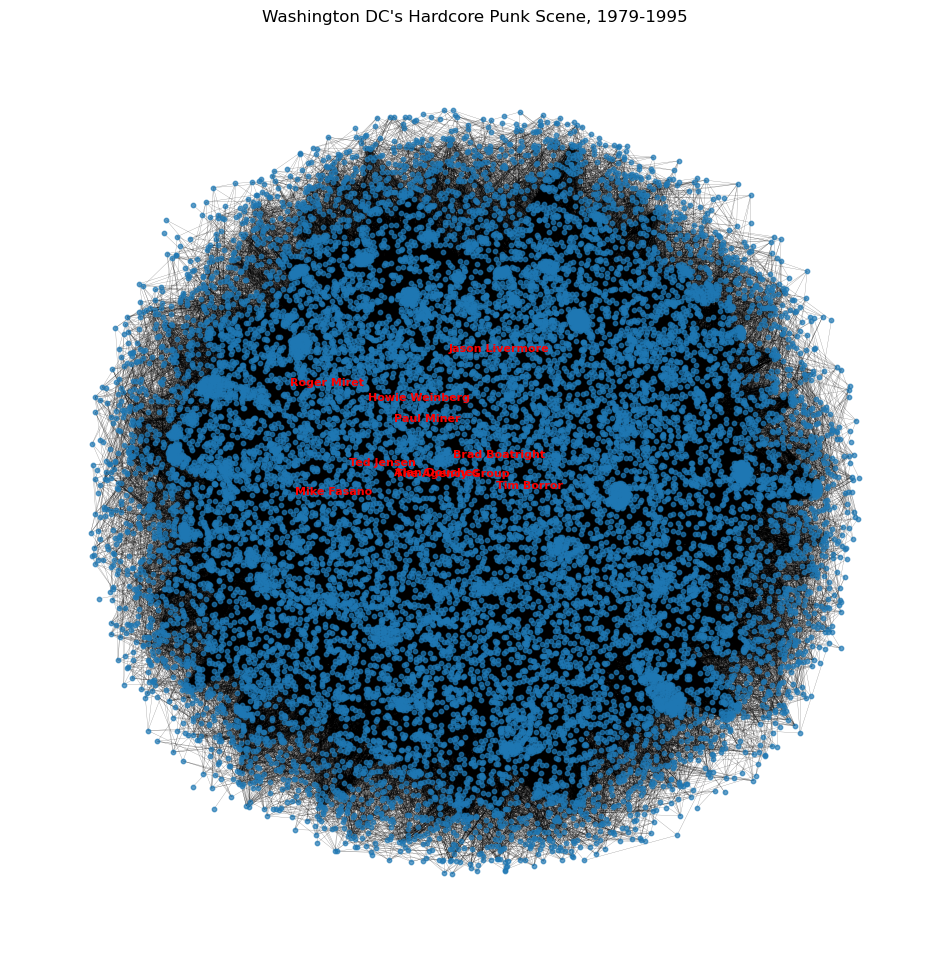

In [ ]:
import matplotlib.pyplot as plt

# Draw the graph with a simple layout
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, seed=42)  # spring layout for better spacing

# Draw nodes and edges (for large graphs, limit number of nodes for clarity)
nx.draw_networkx_nodes(G, pos, node_size=10, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.5)

# Get top 10 artists and their positions
top_10_artists = centrality_named.sort_values('degree_centrality', ascending=False).head(10)

# Create labels dictionary for top 10 artists
labels = {}
for _, row in top_10_artists.iterrows():
    artist_id = row['artist_id']
    artist_name = row['name']
    if artist_id in pos:  # Make sure the artist is in the graph
        labels[artist_id] = artist_name

# Draw labels for top 10 most central artists
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='red', font_weight='bold')

plt.title(f"The Post-War Hardbop Scene in New York - 1955-1965")
plt.axis('off')
plt.show()

In [ ]:
# Save the current matplotlib figure as a PNG to the output folder
plt.savefig(r"C:\Users\maxmo\Dropbox\GDS\Dissertation\discogs\output\ny_bebop_network.png", format='png', dpi=300, bbox_inches='tight')